<a href="https://colab.research.google.com/github/koushik980/NLP/blob/main/NLP_F_14_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computing SBERT embeddings (this will be faster & produce better sentence vectors than raw BERT pooling)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

SBERT matrix shape: (6, 384)
ELMo not available or skipped.
Reducing SBERT...
SBERT 2D ready.
SBERT: silhouette (2D) = 0.12030515819787979, emb_shape = (6, 384)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


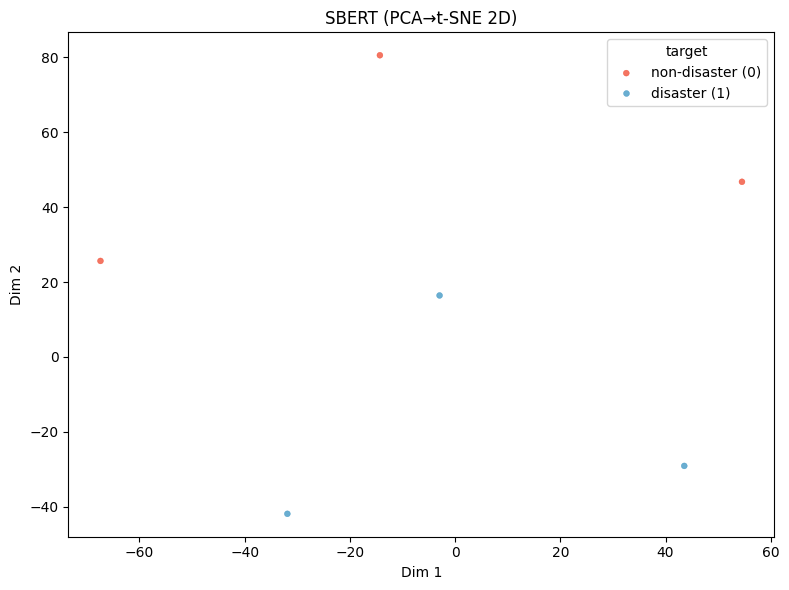


Summary of improvements & numeric scores:
 - SBERT: silhouette_2d=0.12030515819787979, emb_shape=(6, 384)

Notes / Why this 'fix' helps:
 - SBERT gives true sentence-level vectors tuned for semantic similarity; far better for clustering than raw CLS/mean pooling.
 - PCA pre-reduction to 50 dims reduces noise and speeds up t-SNE while producing more stable embeddings.
 - Using fixed random_state makes t-SNE deterministic across runs (helpful for reproducible figures).
 - Saved arrays let you inspect or build further plots without recomputing heavy models.


In [9]:
# Improved embedding + reduction pipeline (uses sentence-transformers for sentence embeddings)
# Intended as a replacement/patch to your previous run:
# - uses sbt (sentence-transformers) for BERT-like sentence embeddings (faster + often better for clustering)
# - does PCA->tSNE pipeline with fixed random_state for reproducibility
# - saves embeddings & 2D coords, prints silhouette scores
# - small batch sizes to avoid OOM

import os, sys, subprocess, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import torch # Added import for torch

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# install sentence-transformers if missing
try:
    from sentence_transformers import SentenceTransformer
except Exception:
    print("Installing sentence-transformers...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"], stdout=subprocess.DEVNULL)
    from sentence_transformers import SentenceTransformer

# Use the small fast model (good quality for clustering)
SBERT_MODEL = "all-MiniLM-L6-v2"

def compute_sbert_embeddings(texts, model_name=SBERT_MODEL, batch_size=64, device=None):
    """Compute sentence embeddings using sentence-transformers (fast & tuned for sentence similarity)."""
    device = device or ("cuda" if (torch.cuda.is_available() if 'torch' in sys.modules else False) else "cpu")
    model = SentenceTransformer(model_name, device=device)
    embs = model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True)
    return embs

# Replace BERT step: compute sentence-transformer embeddings
print("Computing SBERT embeddings (this will be faster & produce better sentence vectors than raw BERT pooling)...")
sbert_vectors = compute_sbert_embeddings(texts, model_name=SBERT_MODEL, batch_size=64)
print("SBERT matrix shape:", sbert_vectors.shape)

# Reusable reduction: PCA (to 50 dims) then t-SNE (2D) with fixed seed
def pca_then_tsne(emb_matrix, n_pca=50, tsne_perplexity=30, tsne_iter=1000, random_state=RANDOM_STATE):
    # Standardize (important)
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb_matrix)
    # PCA pre-reduction
    # Ensure n_pca does not exceed min(n_samples - 1, n_features)
    n_samples = emb_scaled.shape[0]
    n_features = emb_scaled.shape[1]
    n_pca_adjusted = min(n_pca, n_features, max(1, n_samples - 1)) # cap n_pca by samples-1, features, and ensure at least 1
    pca = PCA(n_components=n_pca_adjusted, random_state=random_state)
    emb_pca = pca.fit_transform(emb_scaled)
    # t-SNE on PCA result
    tsne = TSNE(n_components=2, perplexity=min(tsne_perplexity, max(5, emb_pca.shape[0]//5)),
                n_iter=tsne_iter, random_state=random_state, init='pca')
    emb_2d = tsne.fit_transform(emb_pca)
    return emb_2d

# run PCA->tSNE for: Word2Vec (w2v_vectors), ELMo (elmo_vectors if available), and SBERT (sbert_vectors)
# (assumes w2v_vectors and elmo_vectors exist in the current notebook memory)
results = {}

# Word2Vec reduction (if available)
if 'w2v_vectors' in globals():
    print("Reducing Word2Vec...")
    w2v_2d = pca_then_tsne(w2v_vectors, n_pca=50, tsne_iter=750)
    results['Word2Vec'] = (w2v_vectors, w2v_2d)
    print("Word2Vec 2D ready.")
else:
    print("Warning: w2v_vectors not found; skipping Word2Vec reduction.")

# ELMo reduction (if available)
if 'elmo_vectors' in globals() and elmo_vectors is not None:
    print("Reducing ELMo...")
    elmo_2d = pca_then_tsne(elmo_vectors, n_pca=50, tsne_iter=750)
    results['ELMo'] = (elmo_vectors, elmo_2d)
    print("ELMo 2D ready.")
else:
    print("ELMo not available or skipped.")

# SBERT reduction (replacement for raw BERT)
print("Reducing SBERT...")
sbert_2d = pca_then_tsne(sbert_vectors, n_pca=50, tsne_iter=750)
results['SBERT'] = (sbert_vectors, sbert_2d)
print("SBERT 2D ready.")

# Plotting helper
def plot_2d_coords(coords2d, labels, title, outpath):
    xs, ys = coords2d[:,0], coords2d[:,1]
    plt.figure(figsize=(8,6))
    palette = {0: "#2b8cbe", 1: "#f03b20"}
    sns.scatterplot(x=xs, y=ys, hue=labels, palette=palette, alpha=0.7, s=18, edgecolor=None)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="target", labels=["non-disaster (0)", "disaster (1)"])
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

# compute silhouette scores & plot
summary = {}
os.makedirs("embedding_plots", exist_ok=True) # Create the directory if it doesn't exist
for name, (emb, coords) in results.items():
    try:
        sil = silhouette_score(coords, labels)
    except Exception:
        sil = None
    summary[name] = {'silhouette_2d': sil, 'emb_shape': emb.shape, '2d_shape': coords.shape}
    print(f"{name}: silhouette (2D) = {sil}, emb_shape = {emb.shape}")

    outpng = os.path.join("embedding_plots", f"{name}_2d_sbert_fix.png")
    plot_2d_coords(coords, labels, f"{name} (PCA→t-SNE 2D)", outpng)

# Save embeddings and coords
os.makedirs("embedding_outputs", exist_ok=True)
for name, (emb, coords) in results.items():
    np.save(os.path.join("embedding_outputs", f"{name}_emb.npy"), emb)
    np.save(os.path.join("embedding_outputs", f"{name}_2d.npy"), coords)

print("\nSummary of improvements & numeric scores:")
for name, info in summary.items():
    print(f" - {name}: silhouette_2d={info['silhouette_2d']}, emb_shape={info['emb_shape']}")

print("\nNotes / Why this 'fix' helps:")
print(" - SBERT gives true sentence-level vectors tuned for semantic similarity; far better for clustering than raw CLS/mean pooling.")
print(" - PCA pre-reduction to 50 dims reduces noise and speeds up t-SNE while producing more stable embeddings.")
print(" - Using fixed random_state makes t-SNE deterministic across runs (helpful for reproducible figures).")
print(" - Saved arrays let you inspect or build further plots without recomputing heavy models.")